In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [86]:
# Set your folder path
folder_path = "/content/drive/MyDrive/FoodDemandProject_dataset/"

#load  dataset
df=pd.read_csv(folder_path+ "inventory_delivery_forecast_data.csv")



In [87]:
# Sort by date to ensure proper time-series order
df = df.sort_values("delivery_date").reset_index(drop=True)

df.head()

,delivery_date,wings,tenders,fries_reg,fries_large,veggies,dips,drinks,flavours
0,2023-12-30,5714,756,136,190,179,570,246,832
1,2024-01-01,5139,545,131,145,140,471,217,721
2,2024-01-06,5225,577,117,160,157,475,175,718
3,2024-01-08,4682,623,157,137,132,470,237,735
4,2024-01-13,4571,628,144,108,106,388,184,709


In [90]:
# 2. Feature Engineering
df_fe = df.copy()

# Convert 'delivery_date' to datetime objects
df_fe["delivery_date"] = pd.to_datetime(df_fe["delivery_date"])

# Create lag features for each inventory column
for col in df.columns:
    if col not in ["delivery_date"]:
        df_fe[f"{col}_lag1"] = df_fe[col].shift(1)
        df_fe[f"{col}_lag2"] = df_fe[col].shift(2)

# Rolling averages (last 2 deliveries)
for col in df.columns:
    if col not in ["delivery_date"]:
        df_fe[f"{col}_roll2"] = df_fe[col].rolling(window=2).mean()

# Calendar features
df_fe["day_of_week"] = df_fe["delivery_date"].dt.dayofweek
df_fe["month"] = df_fe["delivery_date"].dt.month

# Drop first rows with NaN from lags/rolling
df_fe = df_fe.dropna().reset_index(drop=True)

df_fe.head()

,delivery_date,wings,tenders,fries_reg,fries_large,veggies,dips,drinks,flavours,wings_lag1,...,wings_roll2,tenders_roll2,fries_reg_roll2,fries_large_roll2,veggies_roll2,dips_roll2,drinks_roll2,flavours_roll2,day_of_week,month
0,2024-01-06,5225,577,117,160,157,475,175,718,5139.0,...,5182.0,561.0,124.0,152.5,148.5,473.0,196.0,719.5,5,1
1,2024-01-08,4682,623,157,137,132,470,237,735,5225.0,...,4953.5,600.0,137.0,148.5,144.5,472.5,206.0,726.5,0,1
2,2024-01-13,4571,628,144,108,106,388,184,709,4682.0,...,4626.5,625.5,150.5,122.5,119.0,429.0,210.5,722.0,5,1
3,2024-01-15,4124,614,146,111,103,407,218,680,4571.0,...,4347.5,621.0,145.0,109.5,104.5,397.5,201.0,694.5,0,1
4,2024-01-20,4614,652,116,137,128,440,148,691,4124.0,...,4369.0,633.0,131.0,124.0,115.5,423.5,183.0,685.5,5,1


In [91]:
# 3. Train/Test Split
target_cols = ["wings", "tenders", "fries_reg", "fries_large", "veggies", "dips", "drinks", "flavours"]

X = df_fe.drop(columns=["delivery_date"] + target_cols)
y = df_fe[target_cols]

# Use last 20% of data for testing
split_index = int(len(df_fe) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape


((83, 26), (21, 26))

In [93]:
# 4. Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)




LinearRegression()

In [94]:
# 4b. Train Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

Ridge()

In [95]:
# 5. Evaluation Function
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"{name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}")
    print("-" * 40)
    return preds

# Evaluate both models
lr_preds = evaluate_model("Linear Regression", lr_model, X_test, y_test)
ridge_preds = evaluate_model("Ridge Regression", ridge_model, X_test, y_test)


Linear Regression Performance:
  MAE:  0.00
  RMSE: 0.00
  R²:   1.000
----------------------------------------
Ridge Regression Performance:
  MAE:  0.02
  RMSE: 0.03
  R²:   1.000
----------------------------------------


In [98]:
print("y_test['wings'] values:", y_test["wings"].values)
print("LR Predictions shape and values:", lr_preds.shape, lr_preds[:, 0])
print("Ridge Predictions shape and values:", ridge_preds.shape, ridge_preds[:, 0])


y_test['wings'] values: [4758 4575 4680 5043 5624 5412 5894 5073 4535 5370 5100 4382 4660 5311
 4643 3637 4511 5950 5266 1108 1451]
LR Predictions shape and values: (21, 8) [4758. 4575. 4680. 5043. 5624. 5412. 5894. 5073. 4535. 5370. 5100. 4382.
 4660. 5311. 4643. 3637. 4511. 5950. 5266. 1108. 1451.]
Ridge Predictions shape and values: (21, 8) [4758.00090145 4574.99966337 4679.99971662 5043.00017601 5623.99987339
 5411.99984169 5894.00056993 5072.99966433 4535.00066984 5369.99955468
 5100.0007798  4381.99993773 4660.00056879 5310.99971004 4642.99955822
 3637.00058422 4510.99984784 5950.00063723 5266.00053435 1107.99974944
 1451.0004486 ]


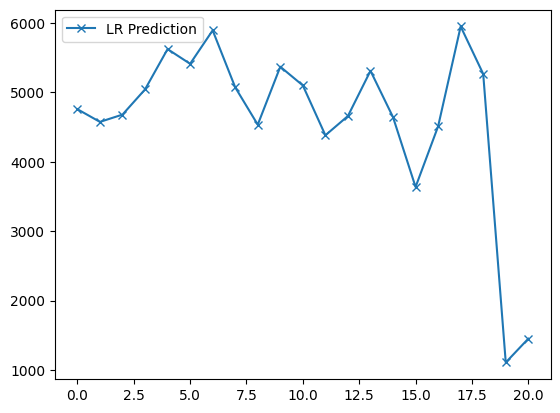

In [99]:
plt.plot(lr_preds[:, 0], label="LR Prediction", marker='x')
plt.legend()
plt.show()


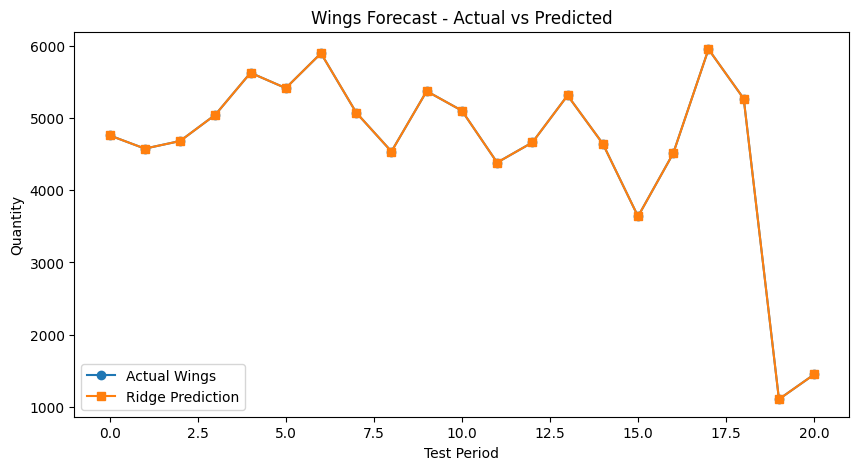

In [101]:
# 6. Forecast Visualization for one target (e.g., wings)
plt.figure(figsize=(10,5))
plt.plot(y_test["wings"].values, label="Actual Wings", marker='o')
plt.plot(ridge_preds[:, 0], label="Ridge Prediction", marker='s')
plt.title("Wings Forecast - Actual vs Predicted")
plt.xlabel("Test Period")
plt.ylabel("Quantity")
plt.legend()
plt.show()


In [102]:
#get the accuracy for LinearRegression
lr_model.score(X_test, y_test)

1.0

In [103]:
#get the accuracy for Ridge
ridge_model.score(X_test, y_test)

0.9999995281749973

In [105]:
#save the model LR
import joblib
joblib.dump(lr_model, 'lr_model.pkl')


['lr_model.pkl']

In [106]:
#sane the model Ridge
joblib.dump(ridge_model, 'ridge_model.pkl')

['ridge_model.pkl']